In [31]:
from __future__ import annotations
from pathlib import Path
from safetensors.torch import load_file
import itertools
from pydantic import BaseModel, ConfigDict
import numpy as np
import tqdm
import torch
from typing import List, Tuple, Literal, Dict

DATASETS = [
    # (numbers are counts for documents, there may be some longer documents -> slightly more chunks)
    "arguana", # 10K
    "fiqa", # 50K -> 20K
    "scidocs", # 25K -> 20K
    "nfcorpus", # 5K
    "hotpotqa", # 100K -> 20K
    "trec-covid", # too much -> 20K
]

MODEL_NAMES = [
    "WhereIsAI/UAE-Large-V1",
    "BAAI/bge-base-en-v1.5",
    "BAAI/bge-large-en-v1.5",
    "BAAI/bge-small-en-v1.5",
    "intfloat/e5-base-v2",
    "intfloat/e5-large-v2",
    "intfloat/e5-small-v2",
    "thenlper/gte-base",
    "thenlper/gte-large",
    "thenlper/gte-small",
    "sentence-transformers/gtr-t5-base",
    "sentence-transformers/gtr-t5-large",
    "mixedbread-ai/mxbai-embed-large-v1",
    "sentence-transformers/sentence-t5-base",
    "sentence-transformers/sentence-t5-large",
    "openai/text-embedding-3-large", # openai
    "openai/text-embedding-3-small", # openai
]

"""
TODO(Adriano) finish this (it might turn into a jupyter notebook idk)

This is an offline script to basically do the same thing as `quadracopter.ipynb`. It will provide functionality (through
multiple click commands) to:
1. Train optimal OLS and batched OLS for all pairs of embedding spaces, speeding up acquisition of our results by 1000x
2. Be able to calculate a set of visualizations that we need for the paper and store them somewhere
    - MAE Table
    - MSE Table
    - Variance Explained Table
    - MAE Explained Table
    - Aggregated of the above (using harmonic/arithmetic means)
    - CKA, Ranking Jaccard Similarity, and Rank score (to compare with the previous tables)
        - Cluster for CKA like the old paper
        - Sample a few random pairs of models and dataset and showcase the triplet loss
        - Cherry pick rank similarity from one model to all others and same for Jaccard like in the paper (this is done both in the
            bofore stitch section and in the after stitch section)
        - Table of rank similarity and jaccard similarity over top 10
    - Kernel maps
        - Sample a few random pairs of models and dataset and showcase the triplet loss
    - UMAP, PCA, and t-SNE for embeddings (combined with a clustering algorithm to get some labels on this shit)
        - Bonus: find some relevant labels for the chunks and then add that in there?
    - MSE/MAE of single cycle
    - Randomly sample some different transformations and calculate over-cycle performance (i.e. so we can see how long
        it takes to get error up by some percent like a half-life -> geometric mean)
    - Random matrix controls for CKA, Jaccard, MAE, MSE, etc... with sampling to provide error bars
(parses outputs from OLS or GD outputs and then creates this shit)
"""


paths_gd = [
    Path("/mnt/align3_drive/adrianoh/dl_final_project_layers/arguana_hf_cartesian_product"),
    Path("/mnt/align3_drive/adrianoh/dl_final_project_layers/nfcorpus_hf_cartesian_product"),
    Path("/mnt/align3_drive/adrianoh/dl_final_project_layers/scidocs_hf_cartesian_product"),
    Path("/mnt/align3_drive/adrianoh/dl_final_project_layers/trec-covid_hf_cartesian_product"),
    Path("/mnt/align3_drive/adrianoh/dl_final_project_layers/fiqa_hf_cartesian_product"),
    Path("/mnt/align3_drive/adrianoh/dl_final_project_layers/hotpotqa_hf_cartesian_product"),
]
paths_ols = [
    Path("/mnt/align3_drive/adrianoh/dl_final_project_layers/ols_all_datasets")
]

class LossResultsLineEntry(BaseModel):
    epoch: int
    train_mse: float
    train_mae: float
    test_mse: float
    test_mae: float

class LossResults(BaseModel):
    model_config = ConfigDict(arbitrary_types_allowed=True)
    train_mses: torch.Tensor
    train_maes: torch.Tensor
    validation_mses: torch.Tensor
    validation_maes: torch.Tensor

class StitchPair(BaseModel):
    source: str
    target: str
    dataset: str
    mode: Literal["affine", "affine_ols"] = "affine" 

class TableCreator:
    def __init__(self, paths: List[Path]):
        self.paths = paths

    def __load_stitch_info(self, path: Path) -> StitchPair:
        name = "stitch_info.json" if (path / "stitch_info.json").exists() else "stitch_info_pairs.json"
        with open(path / name, "r") as f:
            return StitchPair.model_validate_json(f.read())

    def __load_loss_results(self, path: Path) -> LossResults:
        with open(path / "log.jsonl", "r") as f:
            les = [LossResultsLineEntry.model_validate_json(line.strip()) for line in f if len(line.strip()) > 0]
        return LossResults(
            train_mses=torch.tensor([le.train_mse for le in les]),
            train_maes=torch.tensor([le.train_mae for le in les]),
            validation_mses=torch.tensor([le.test_mse for le in les]),
            validation_maes=torch.tensor([le.test_mae for le in les]),
        )

    def __get_minimal_mse_mae(self, loss_results: LossResults) -> torch.Tensor:
        train_mse, validation_mse = torch.min(loss_results.train_mses).item(), torch.min(loss_results.validation_mses).item()
        train_mae, validation_mae = torch.min(loss_results.train_maes).item(), torch.min(loss_results.validation_maes).item()
        return train_mse, validation_mse, train_mae, validation_mae

    def get_all_table_elements(self) -> Tuple[Dict[str, int], Dict[str, int], Dict[str, torch.Tensor], Dict[str, torch.Tensor]]:
        """
        Get a table of the minimal MSE and MAE out of all the models and datasets.
        """
        ################ 1. Load parent paths and sanity test ################
        jsonl_files = []
        # NOTE: log.jsonl = losses
        for path in self.paths:
            jsonl_files.extend(list(path.glob("**/*.jsonl")))
        # ---- Sanity Check Files Present ----
        parents = set([jsonl_file.parent for jsonl_file in jsonl_files])
        assert all((p / "log.jsonl").exists() for p in tqdm.tqdm(parents)) # get the losses that we will plit (i.e. MSEs and MAEs)
        assert all((p / "stitch_info.json").exists() or (p / "stitch_info_pairs.json").exists() for p in tqdm.tqdm(parents)) # get information about pair of models, etc...
        # TODO(Adriano) it appears that in some cases I forgot to measure this
        # assert all((p / "linear_transform.safetensors").exists() for p in tqdm.tqdm(parents)) # get layers if we care about it <--- technically not use rn, but sans
        info_losses: List[Tuple[StitchPair, LossResults]] = [
            (self.__load_stitch_info(p), self.__load_loss_results(p)) for p in parents
        ]
        # ---- Sanity Check Model-Dataset Pairs Used ----
        _expected_model_dataset_pairs_used = set(x for x in itertools.product(DATASETS, MODEL_NAMES, MODEL_NAMES) if x[1] != x[2]) # both directions, not equal
        for info, _ in tqdm.tqdm(info_losses):
            entry = (info.dataset, info.source, info.target)
            assert entry in _expected_model_dataset_pairs_used # Make sure not already passed
            _expected_model_dataset_pairs_used.remove(entry)
        if len(_expected_model_dataset_pairs_used) > 0:
            for entry in _expected_model_dataset_pairs_used: # [DEBUG]
                print(entry) # [DEBUG]
        assert len(_expected_model_dataset_pairs_used) == 0, f"Expected {len(_expected_model_dataset_pairs_used)} model-dataset pairs, got {len(info_losses)}"
        ################ 2. Populate the tables ################
        # TODO(Adriano) find a way to permute this intelligently?
        model2idx = {model: i for i, model in enumerate(MODEL_NAMES)}
        idx2model = {i: model for model, i in model2idx.items()}
        dataset2table_train_mse = {dataset: -1 * torch.ones(len(MODEL_NAMES), len(MODEL_NAMES)) for dataset in DATASETS}
        dataset2table_validation_mse = {dataset: -1 * torch.ones(len(MODEL_NAMES), len(MODEL_NAMES)) for dataset in DATASETS}
        dataset2table_train_mae = {dataset: -1 * torch.ones(len(MODEL_NAMES), len(MODEL_NAMES)) for dataset in DATASETS}
        dataset2table_validation_mae = {dataset: -1 * torch.ones(len(MODEL_NAMES), len(MODEL_NAMES)) for dataset in DATASETS}

        for info, loss_results in tqdm.tqdm(info_losses):
            # ---- Fetch indices ----
            src_idx, tgt_idx = model2idx[info.source], model2idx[info.target]
            # ---- Sanity Check ----
            assert dataset2table_train_mse[info.dataset][src_idx, tgt_idx] == -1, f"Dataset {info.dataset} already has a value at {src_idx, tgt_idx}"
            assert dataset2table_validation_mse[info.dataset][src_idx, tgt_idx] == -1, f"Dataset {info.dataset} already has a value at {src_idx, tgt_idx}"
            assert dataset2table_train_mae[info.dataset][src_idx, tgt_idx] == -1, f"Dataset {info.dataset} already has a value at {src_idx, tgt_idx}"
            assert dataset2table_validation_mae[info.dataset][src_idx, tgt_idx] == -1, f"Dataset {info.dataset} already has a value at {src_idx, tgt_idx}"
            # ---- Fill in da tables ----
            train_mse, validation_mse, train_mae, validation_mae = self.__get_minimal_mse_mae(loss_results)
            dataset2table_train_mse[info.dataset][src_idx, tgt_idx] = train_mse
            dataset2table_validation_mse[info.dataset][src_idx, tgt_idx] = validation_mse
            dataset2table_train_mae[info.dataset][src_idx, tgt_idx] = train_mae
            dataset2table_validation_mae[info.dataset][src_idx, tgt_idx] = validation_mae
        # ---- Fill diagonal with 0s ----
        for dataset in DATASETS:
            for i in range(len(MODEL_NAMES)):
                assert dataset2table_train_mse[dataset][i, i] == -1, f"Dataset {dataset} already has a value at {i, i}"
                assert dataset2table_validation_mse[dataset][i, i] == -1, f"Dataset {dataset} already has a value at {i, i}"
                assert dataset2table_train_mae[dataset][i, i] == -1, f"Dataset {dataset} already has a value at {i, i}"
                assert dataset2table_validation_mae[dataset][i, i] == -1, f"Dataset {dataset} already has a value at {i, i}"
                dataset2table_train_mse[dataset][i, i] = 0
                dataset2table_validation_mse[dataset][i, i] = 0
                dataset2table_train_mae[dataset][i, i] = 0
                dataset2table_validation_mae[dataset][i, i] = 0
        ################ 3. Sanity Check Tables were filled correctly ################
        assert all(0 <= d.min() <= d.max() for d in dataset2table_train_mse.values())
        assert all(0 <= d.min() <= d.max() for d in dataset2table_validation_mse.values())
        assert all(0 <= d.min() <= d.max() for d in dataset2table_train_mae.values())
        assert all(0 <= d.min() <= d.max() for d in dataset2table_validation_mae.values())
        # ret
        return model2idx, idx2model, dataset2table_train_mse, dataset2table_validation_mse, dataset2table_train_mae, dataset2table_validation_mae

In [32]:
creator1 = TableCreator(paths_gd)
creator2 = TableCreator(paths_ols)

In [33]:
(
    model2idx,
    idx2model,
    dataset2table_train_mse,
    dataset2table_validation_mse,
    dataset2table_train_mae,
    dataset2table_validation_mae
) = creator1.get_all_table_elements()
example_table = dataset2table_train_mse["arguana"]
print(example_table) # should be a nice torch tensor, 17 x 17


100%|██████████| 1632/1632 [00:00<00:00, 15707.45it/s]

tensor([[0.0000e+00, 2.1409e-04, 1.7688e-05, 3.8022e-04, 1.4615e-04, 1.2339e-04,
         2.5228e-04, 1.1638e-04, 3.3081e-05, 2.1894e-04, 2.3299e-04, 2.2096e-04,
         5.3694e-06, 9.4156e-05, 1.2276e-04, 1.1722e-04, 1.9921e-04],
        [1.9851e-04, 0.0000e+00, 1.8212e-04, 3.8609e-04, 1.3326e-04, 1.3031e-04,
         2.5906e-04, 4.0098e-05, 8.7585e-05, 2.2226e-04, 2.4388e-04, 2.3890e-04,
         1.8207e-04, 1.0100e-04, 1.3619e-04, 1.2865e-04, 2.1820e-04],
        [1.7824e-05, 2.1355e-04, 0.0000e+00, 3.8432e-04, 1.4492e-04, 1.2234e-04,
         2.5182e-04, 1.1819e-04, 3.5541e-05, 2.2295e-04, 2.3854e-04, 2.2654e-04,
         2.1329e-05, 9.6897e-05, 1.2671e-04, 1.1975e-04, 2.0493e-04],
        [2.4368e-04, 2.6703e-04, 2.2255e-04, 0.0000e+00, 1.7826e-04, 1.4847e-04,
         2.5177e-04, 1.4171e-04, 1.0531e-04, 6.8418e-05, 2.8192e-04, 2.7708e-04,
         2.2453e-04, 1.1663e-04, 1.5691e-04, 1.4592e-04, 2.5209e-04],
        [2.0576e-04, 2.0061e-04, 1.8838e-04, 4.1758e-04, 0.0000e+00, 1.1

In [37]:
from matplotlib import pyplot as plt
import numpy as np

# Set up the figure size and style
plt.style.use('default')  # Use default matplotlib style
plt.rcParams['figure.facecolor'] = 'white'  # Set white background
plt.rcParams['axes.facecolor'] = 'white'  # Set white plot background
plt.rcParams['axes.grid'] = True  # Enable grid
plt.rcParams['grid.alpha'] = 0.3  # Subtle grid
fig_size = (15, 10)

# Log plot version
def plot_all_datasets_tables(
        dataset2table_train_mse: Dict[str, torch.Tensor],
        dataset2table_validation_mse: Dict[str, torch.Tensor],
        dataset2table_validation_mae: Dict[str, torch.Tensor],
        use_log_plot: bool = True,
        log_base: float = 10.0
    ):
    if log_base != 10.0:
        raise NotImplementedError(f"Log base {log_base} is not supported")
    for dataset in dataset2table_train_mse.keys():
        # Create figure with 2 subplots side by side
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=fig_size)
        fig.suptitle(f'Log Error Metrics for {dataset.capitalize()} Dataset', fontsize=16)
        
        # Convert zeros to small value before taking log
        mse_data = dataset2table_validation_mse[dataset].clone()
        mae_data = dataset2table_validation_mae[dataset].clone()
        
        # Replace zeros with -inf for log plot
        if use_log_plot:
            mse_data[mse_data == 0] = float('-inf')
            mae_data[mae_data == 0] = float('-inf')
        
        # Plot log MSE
        if use_log_plot:
            mse_data[mse_data > 0] = torch.log10(mse_data[mse_data > 0])
        im1 = ax1.imshow(mse_data)
        ax1.set_title('Log10 Validation MSE')
        plt.colorbar(im1, ax=ax1)
        
        # Plot log MAE
        mae_data[mae_data > 0] = torch.log10(mae_data[mae_data > 0])
        im2 = ax2.imshow(mae_data)
        ax2.set_title('Log10 Validation MAE')
        plt.colorbar(im2, ax=ax2)
        
        # Add labels
        for ax in [ax1, ax2]:
            ax.set_xlabel('Target Model Index')
            ax.set_ylabel('Source Model Index')
            
        plt.tight_layout()
        plt.show()


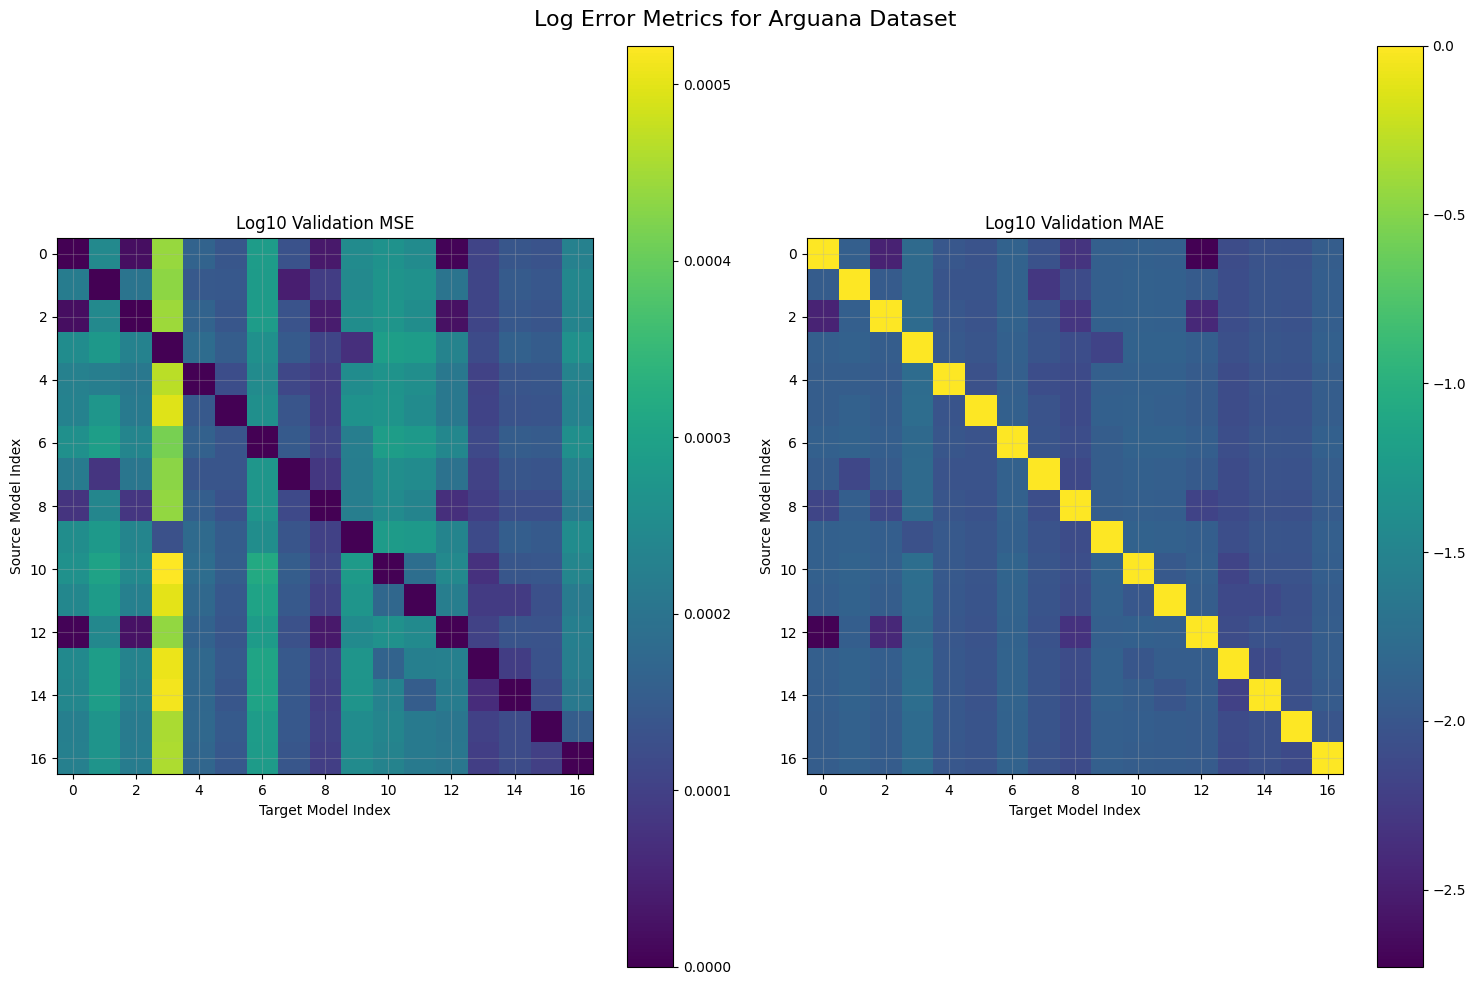

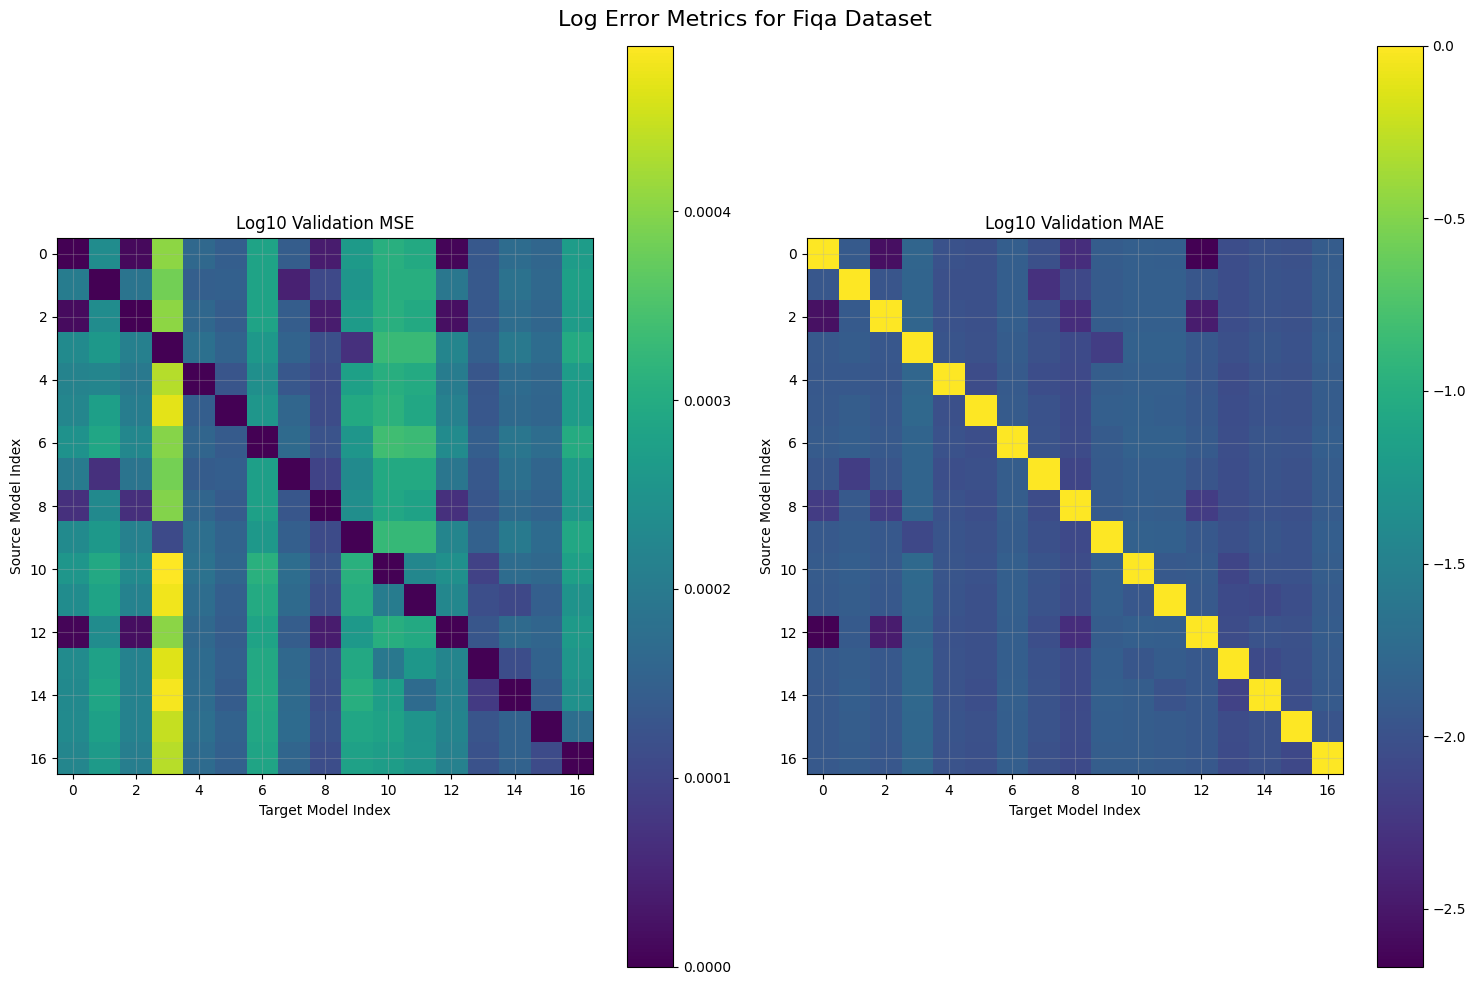

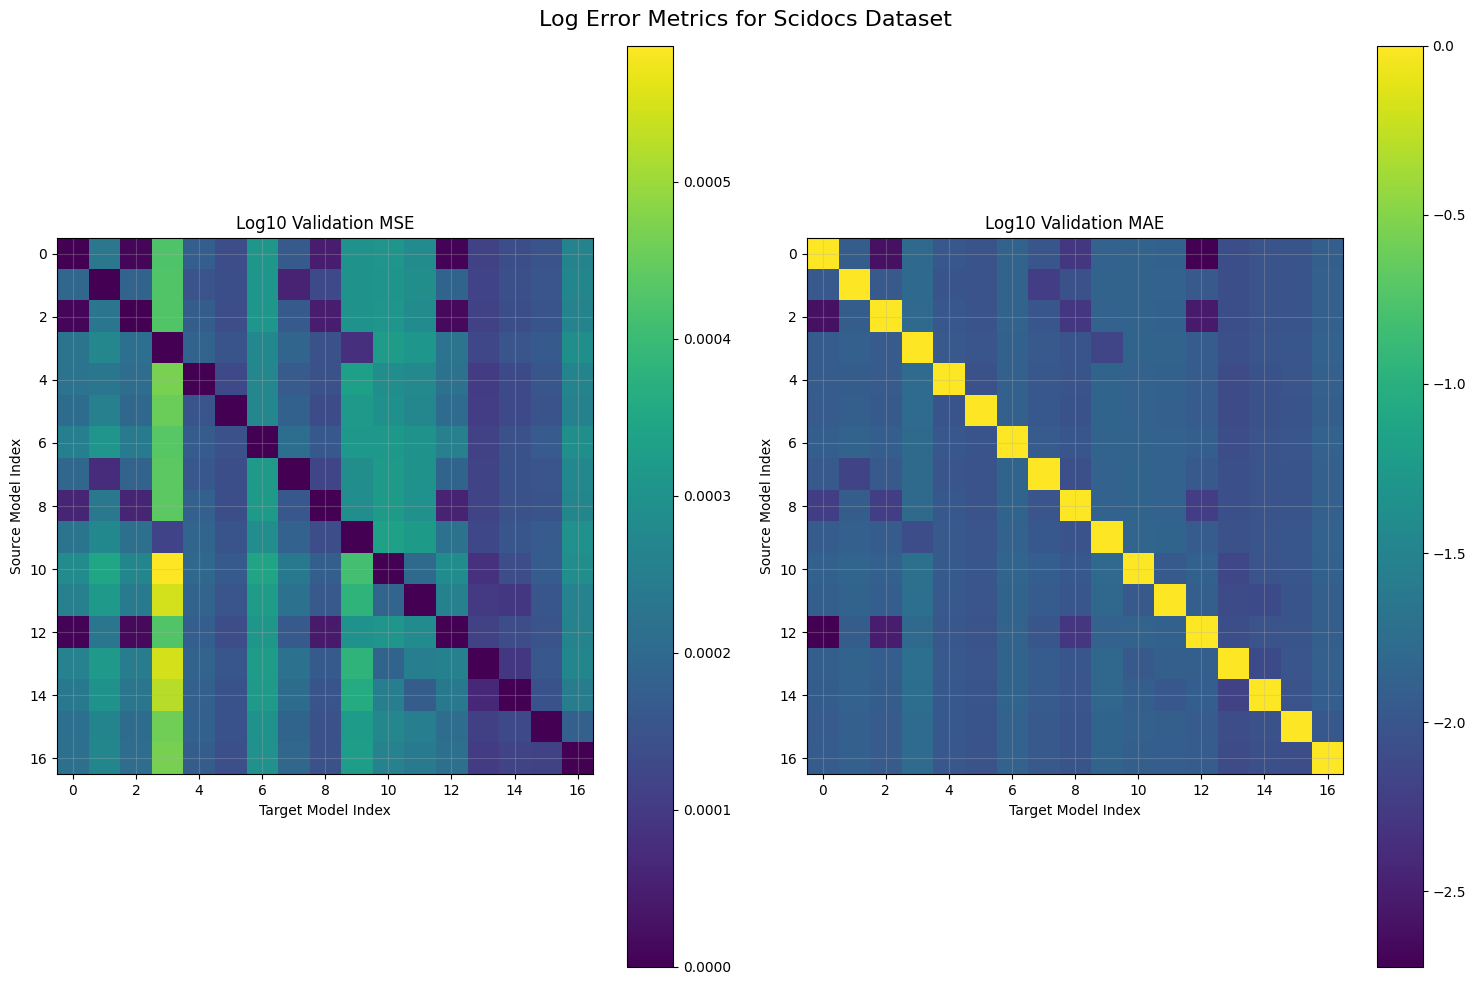

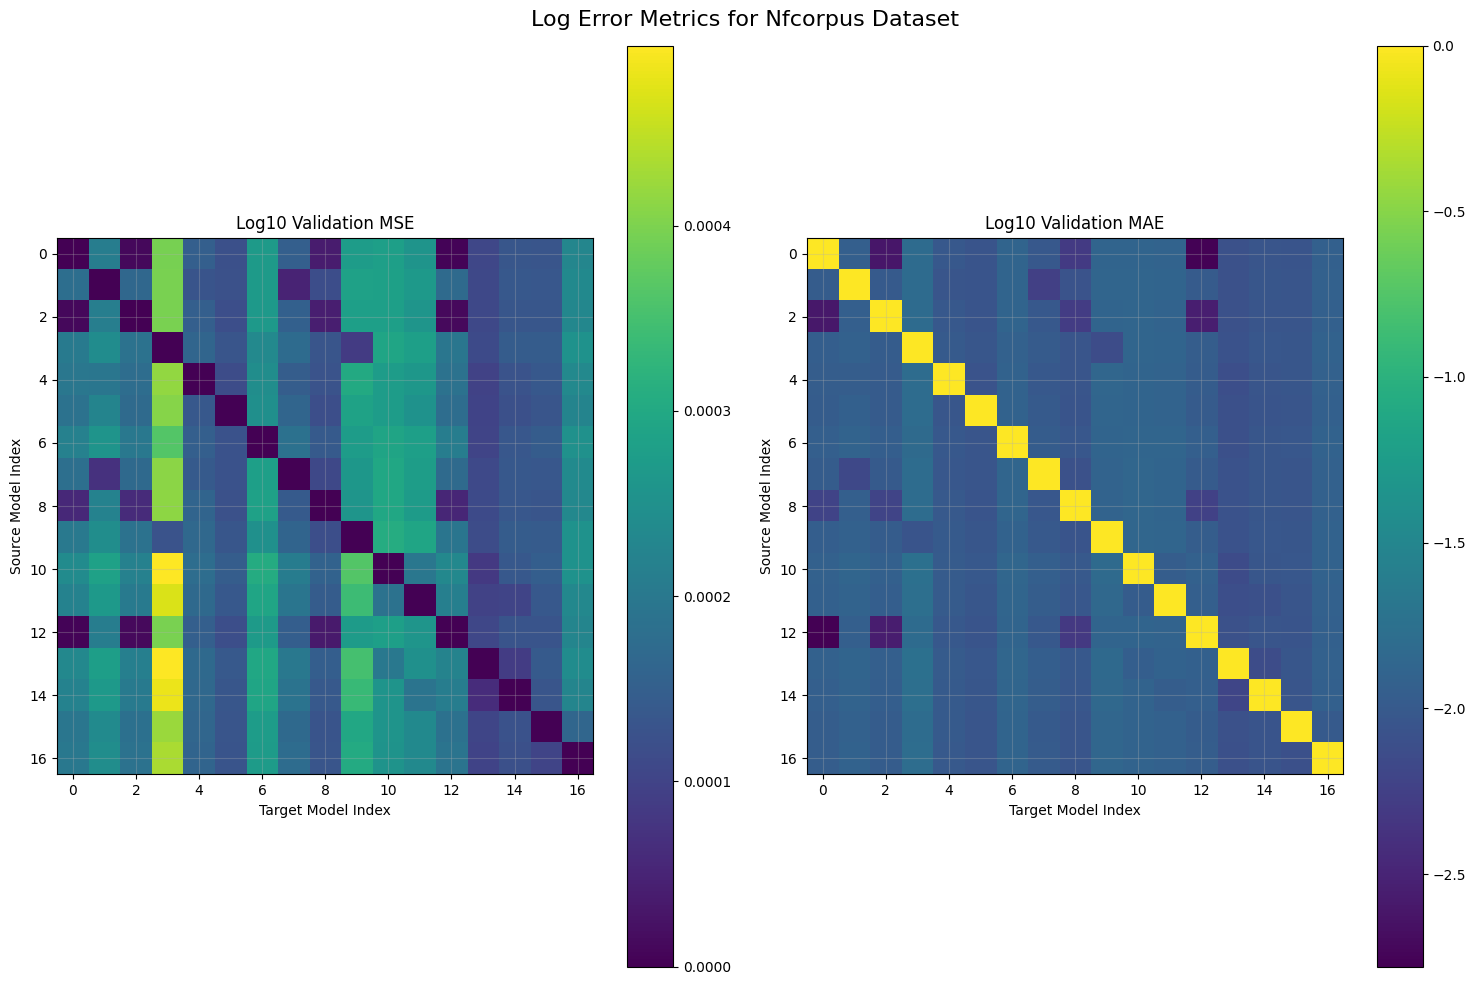

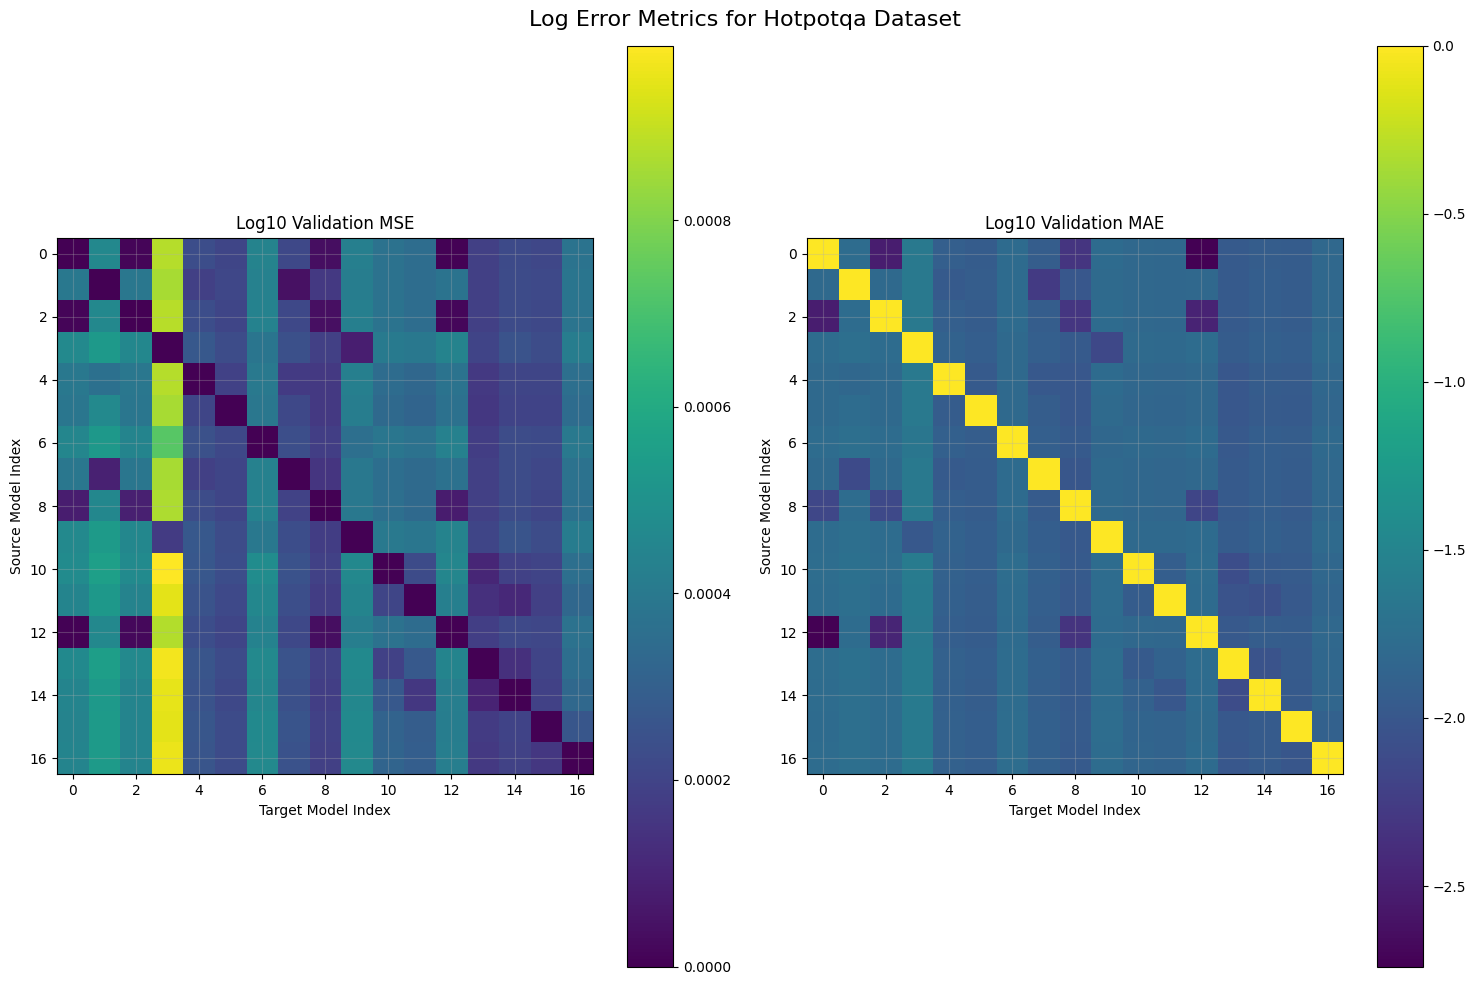

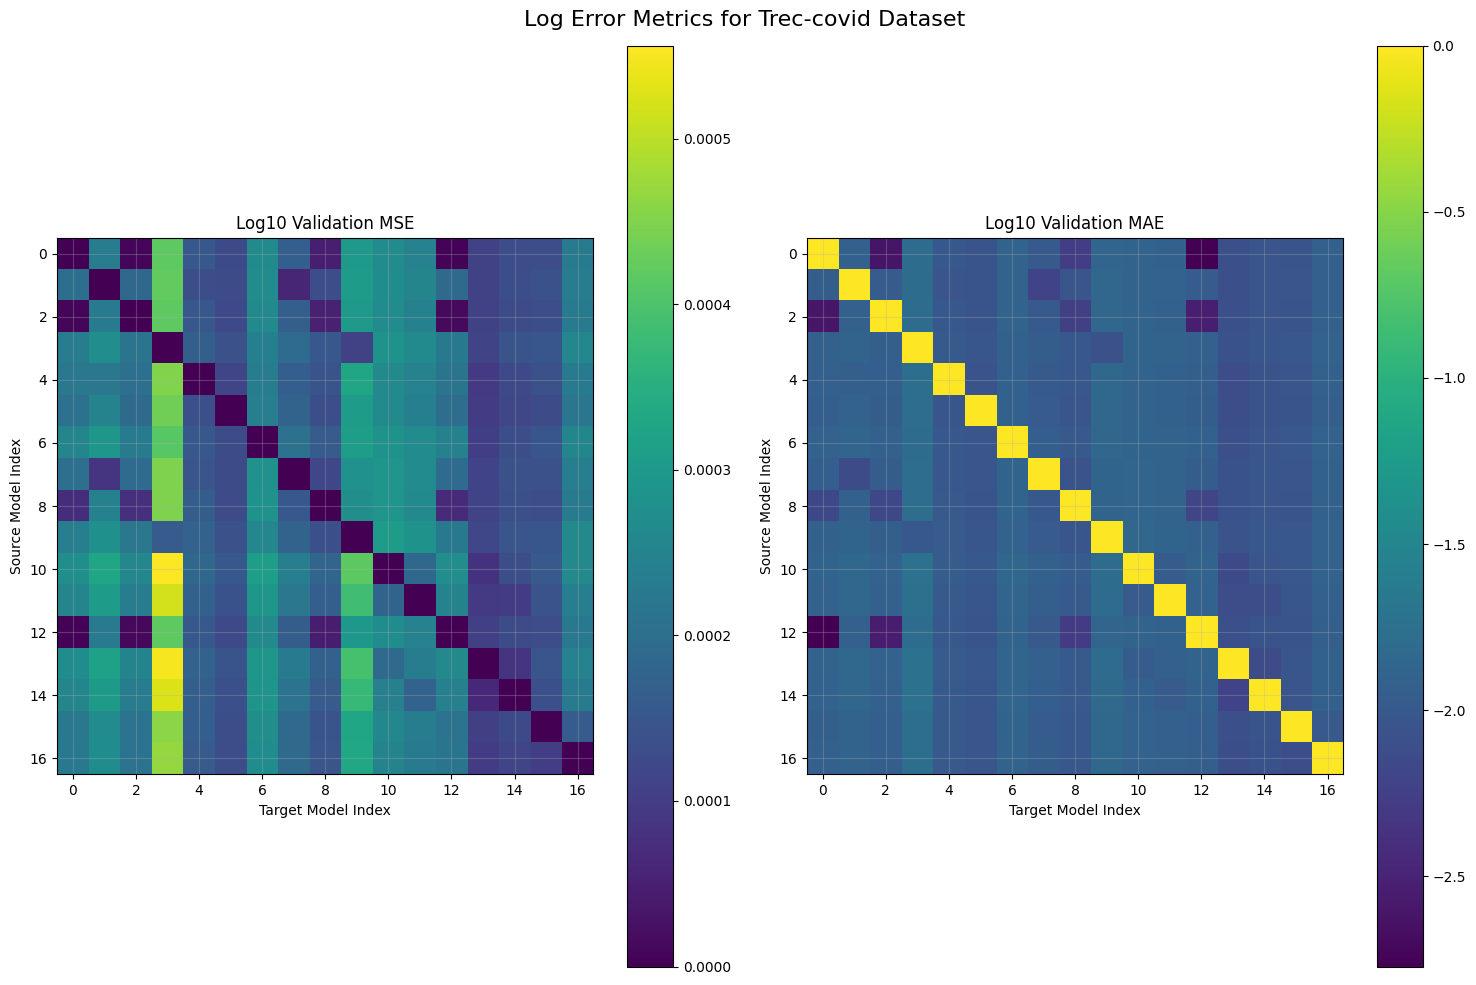

In [38]:
# plot without log
plot_all_datasets_tables(dataset2table_train_mse, dataset2table_validation_mse, dataset2table_validation_mae, use_log_plot=False)

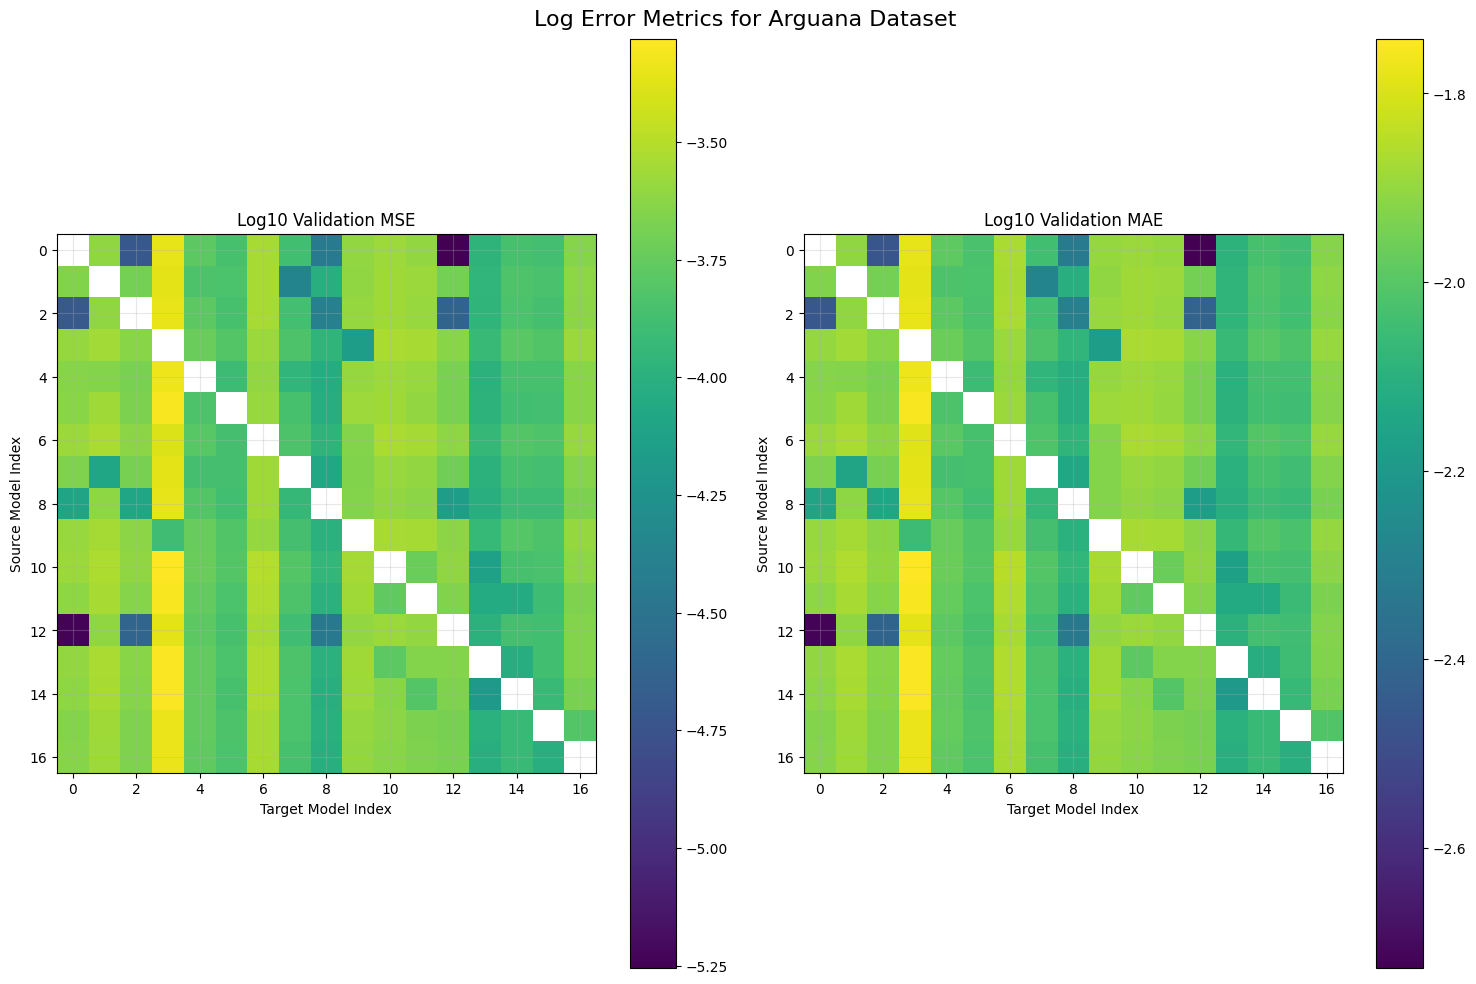

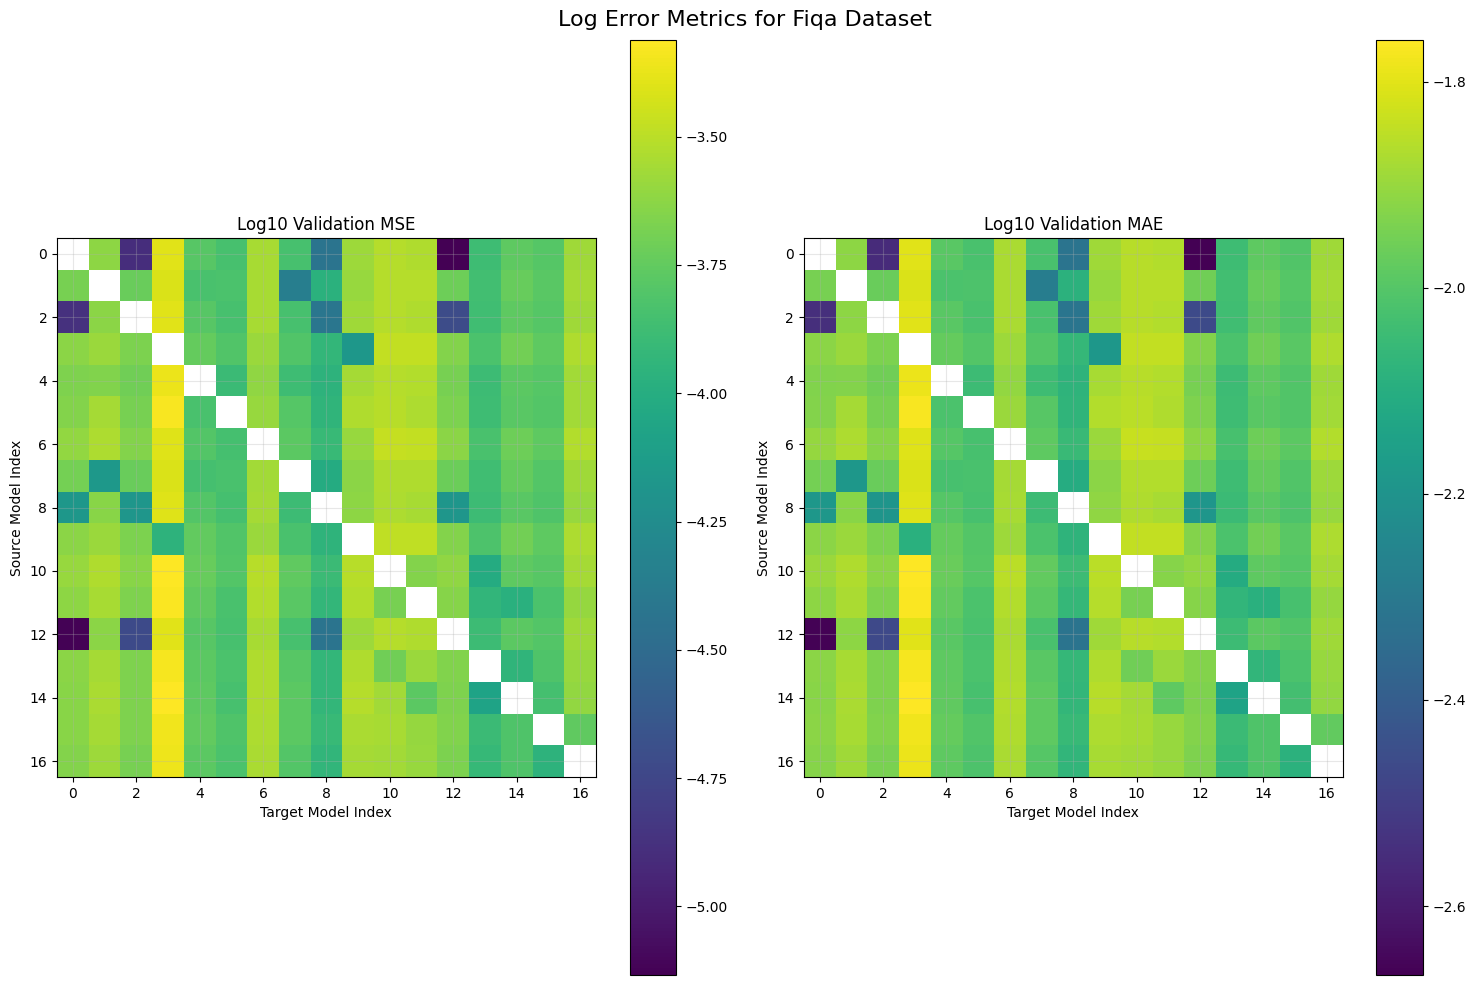

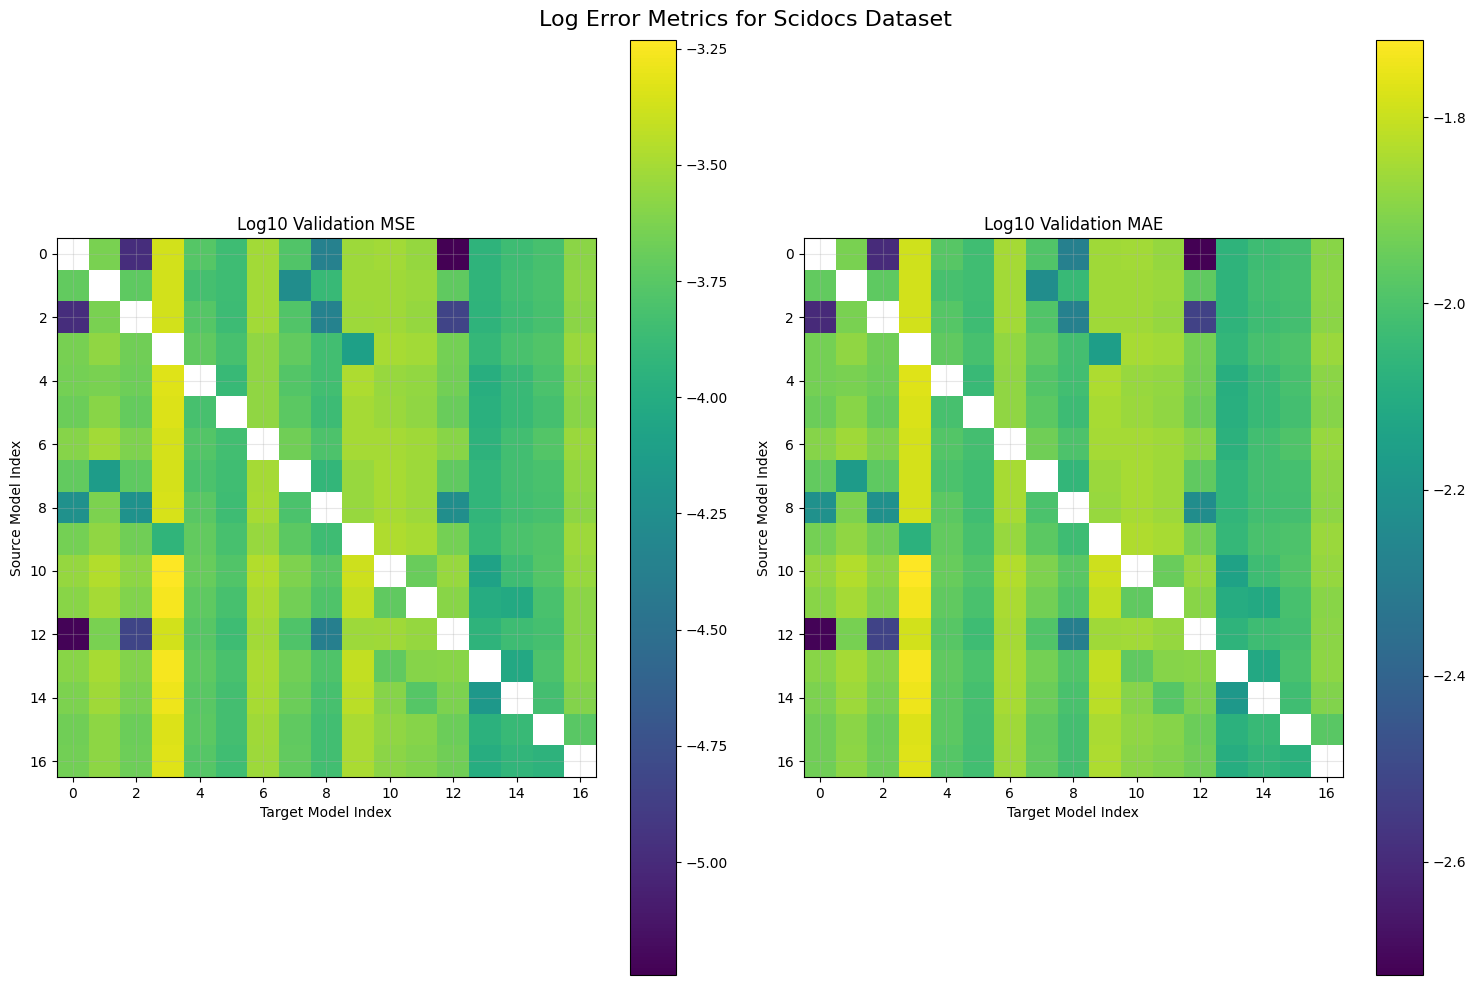

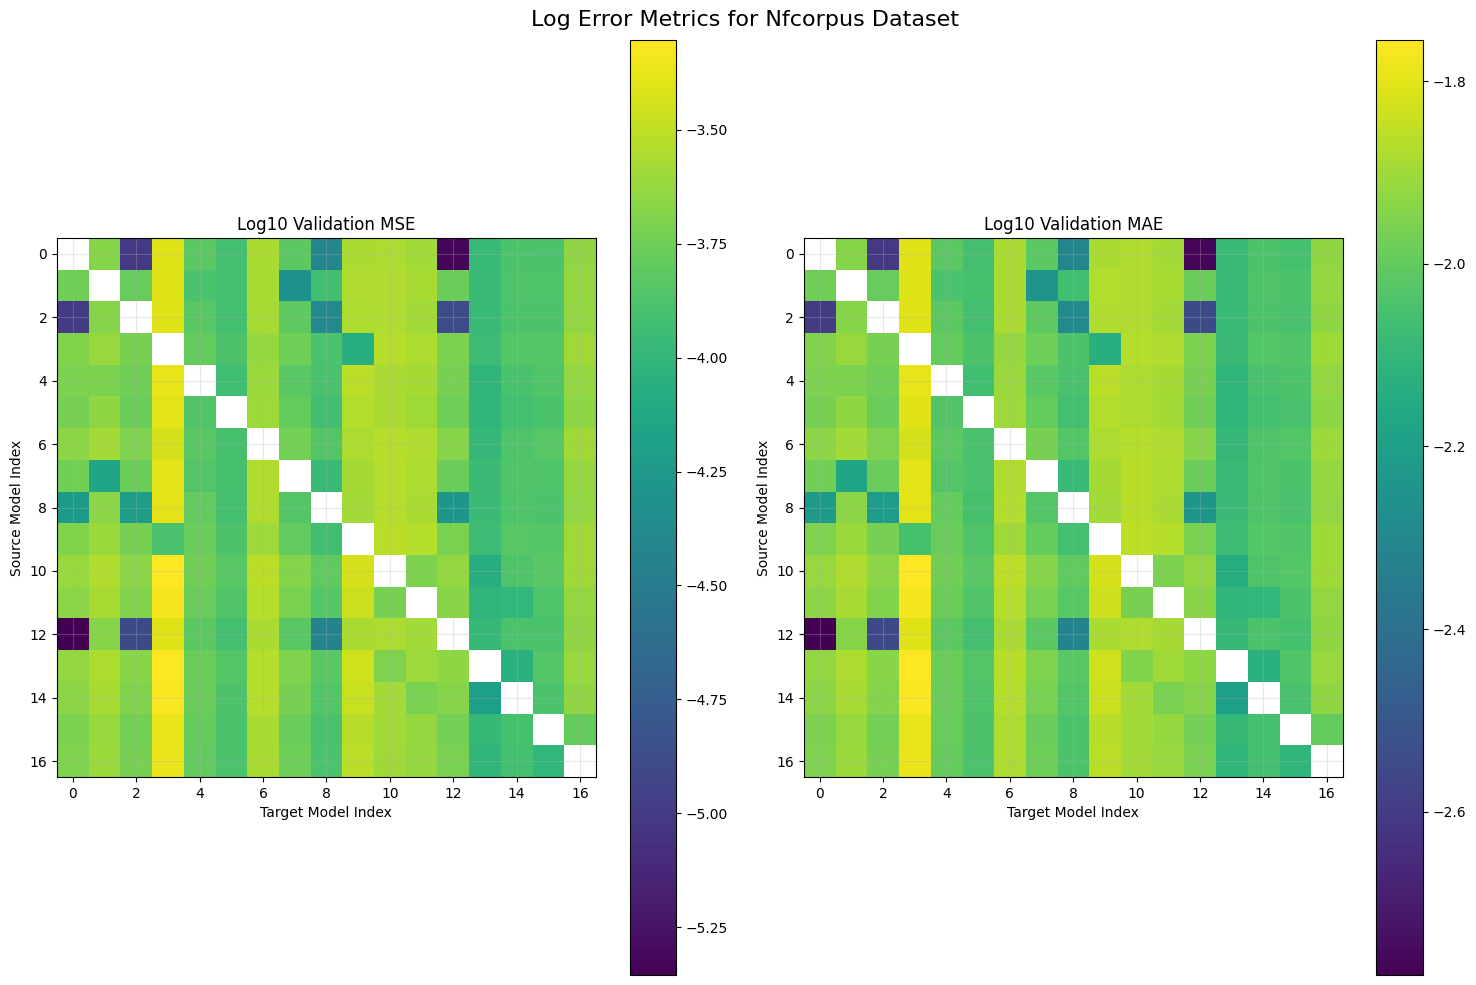

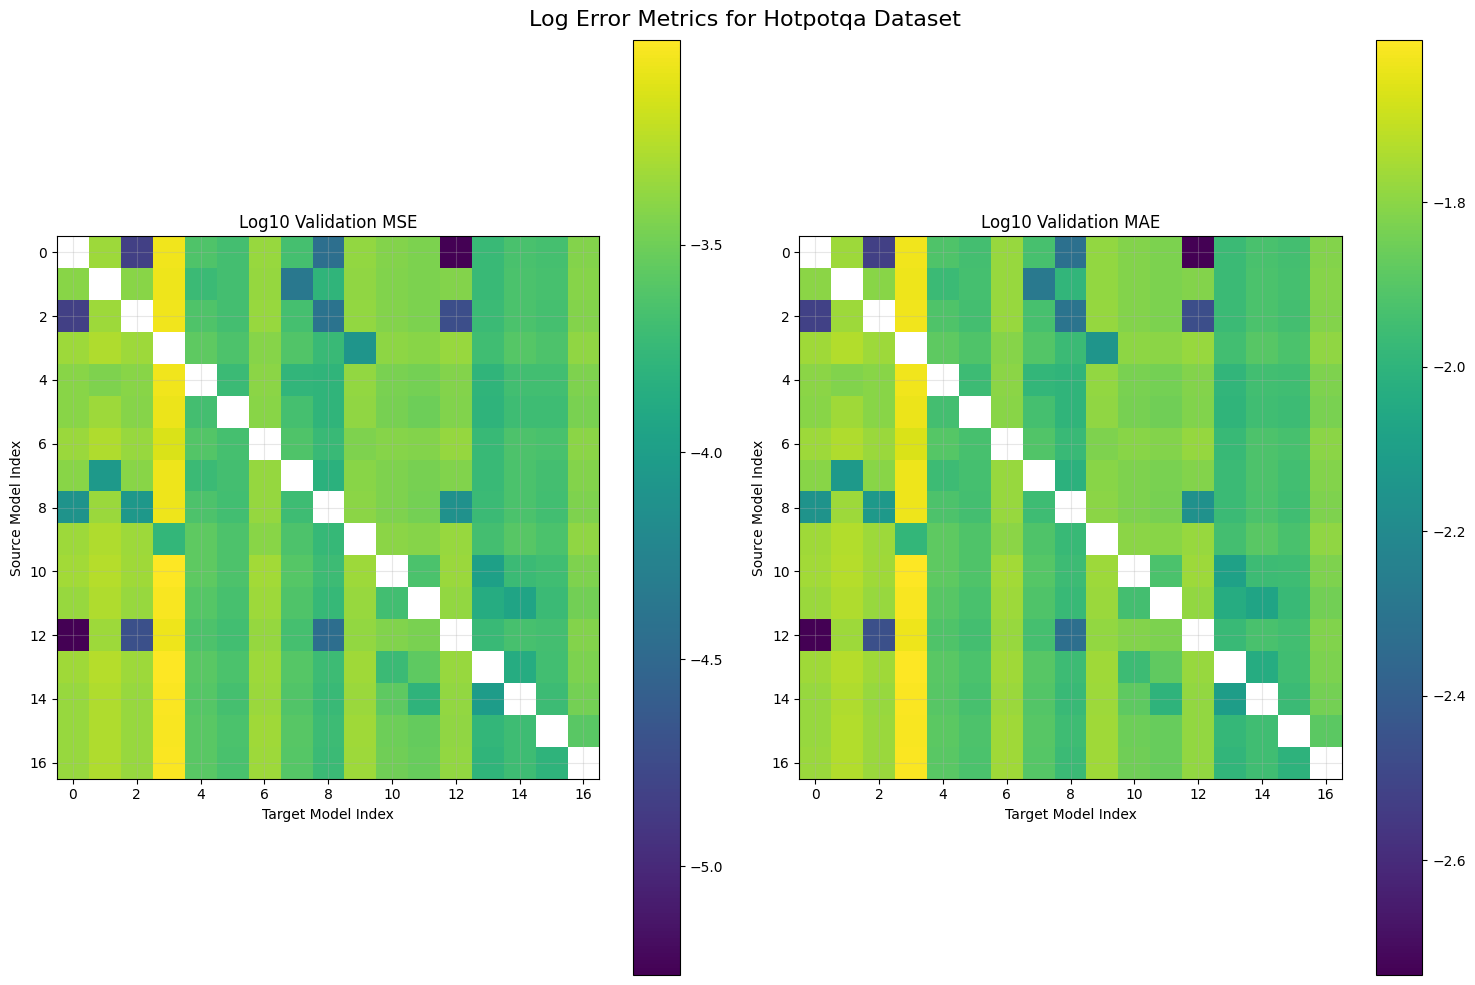

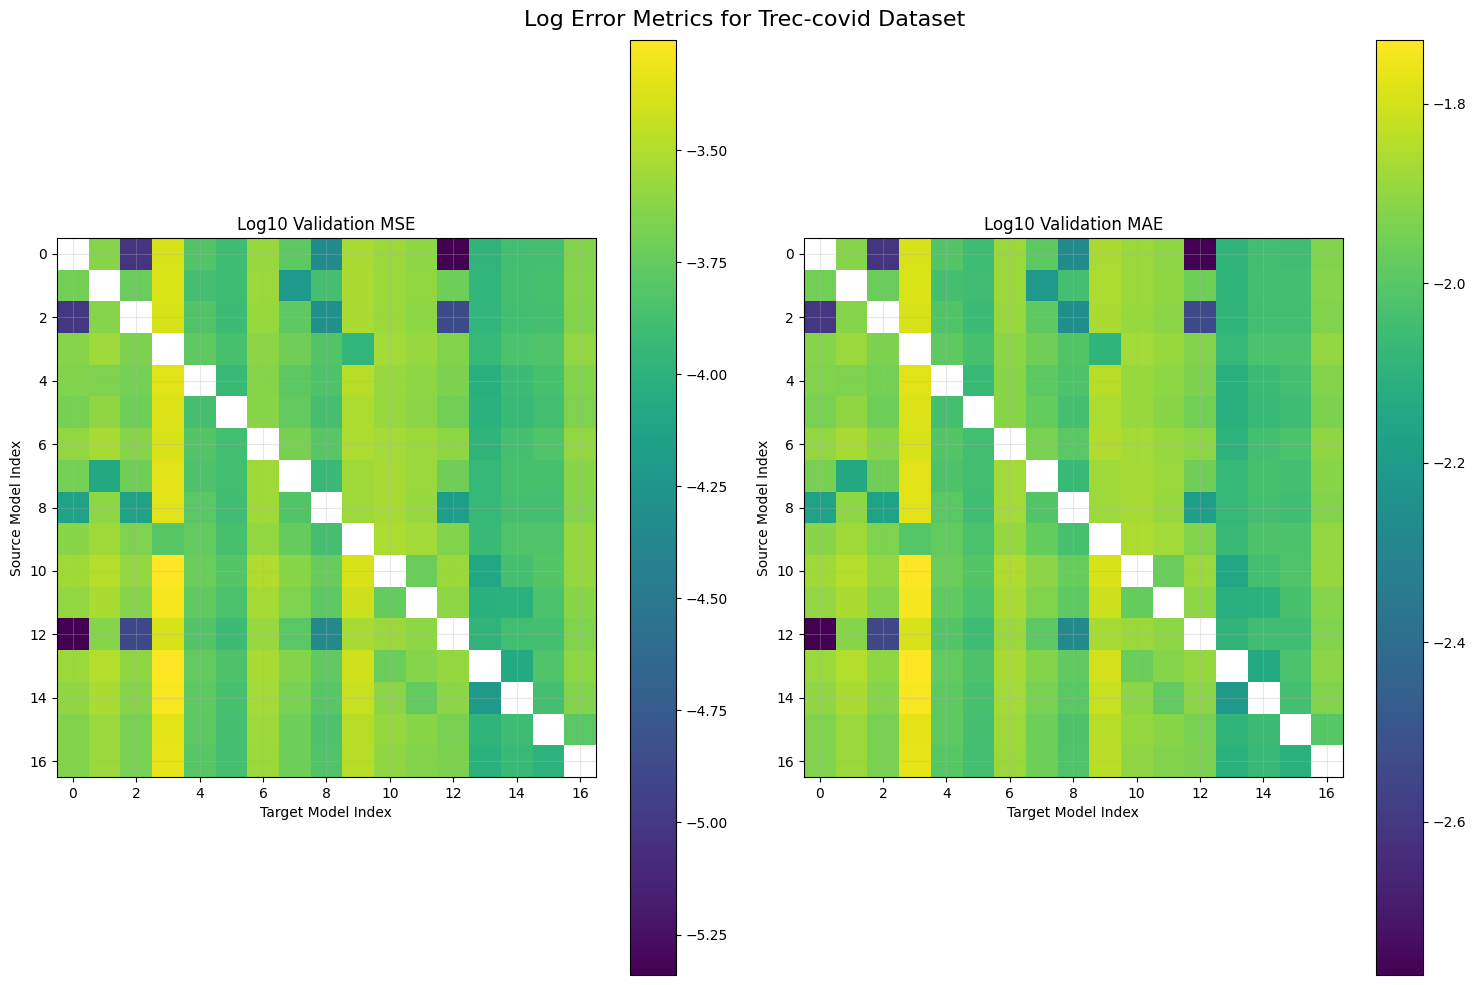

In [39]:
# plot with log
plot_all_datasets_tables(dataset2table_train_mse, dataset2table_validation_mse, dataset2table_validation_mae, use_log_plot=True)

100%|██████████| 1632/1632 [00:00<00:00, 14377.09it/s]


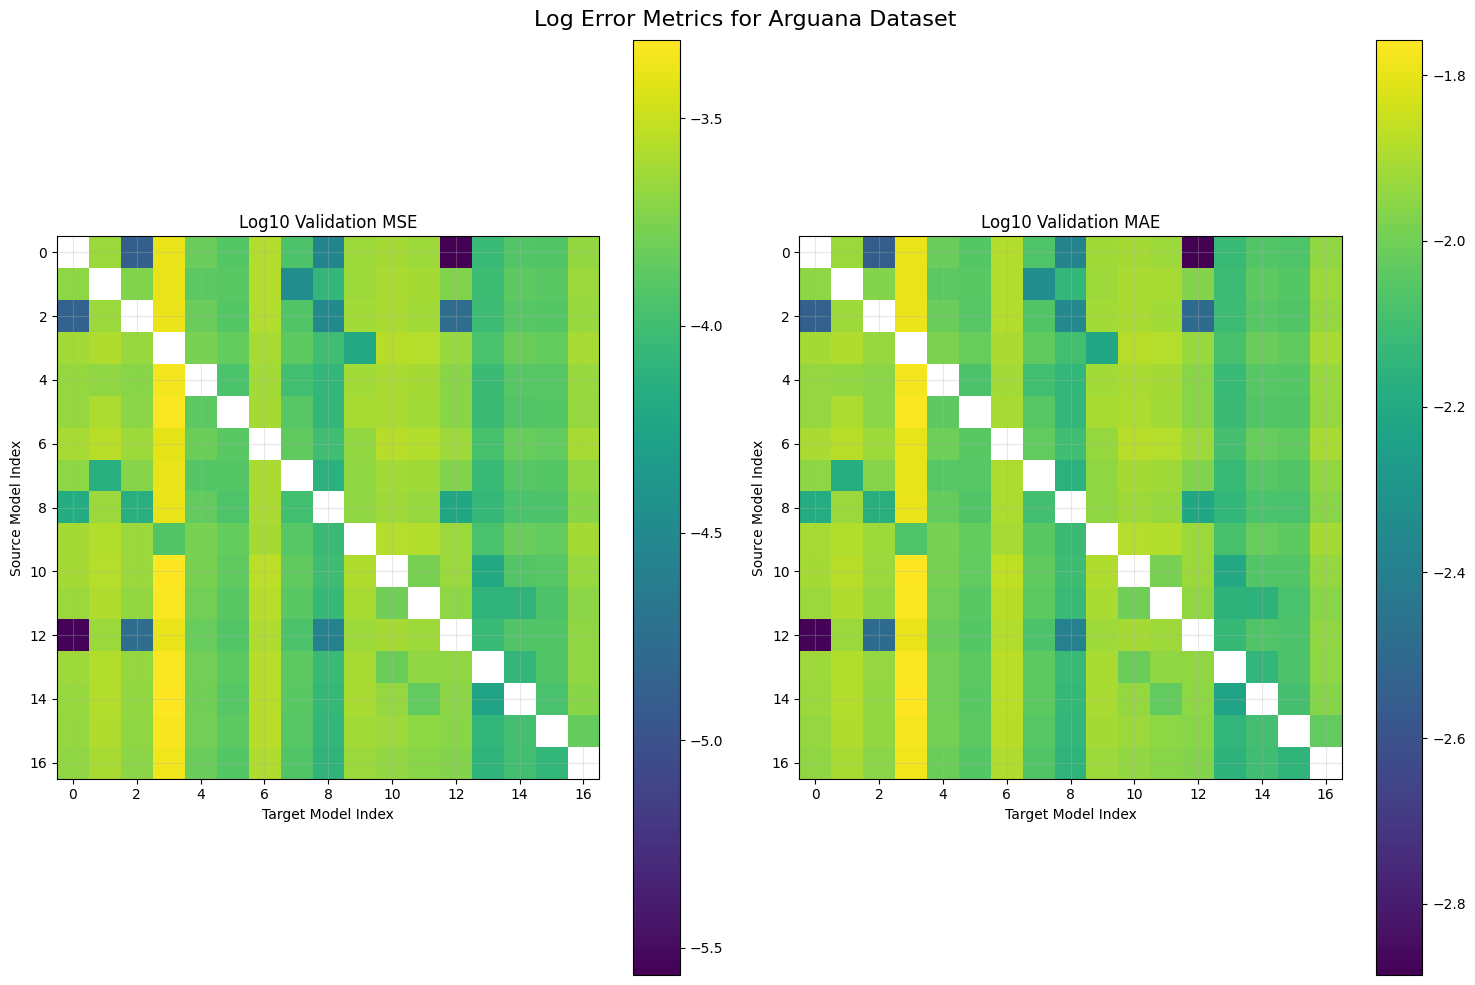

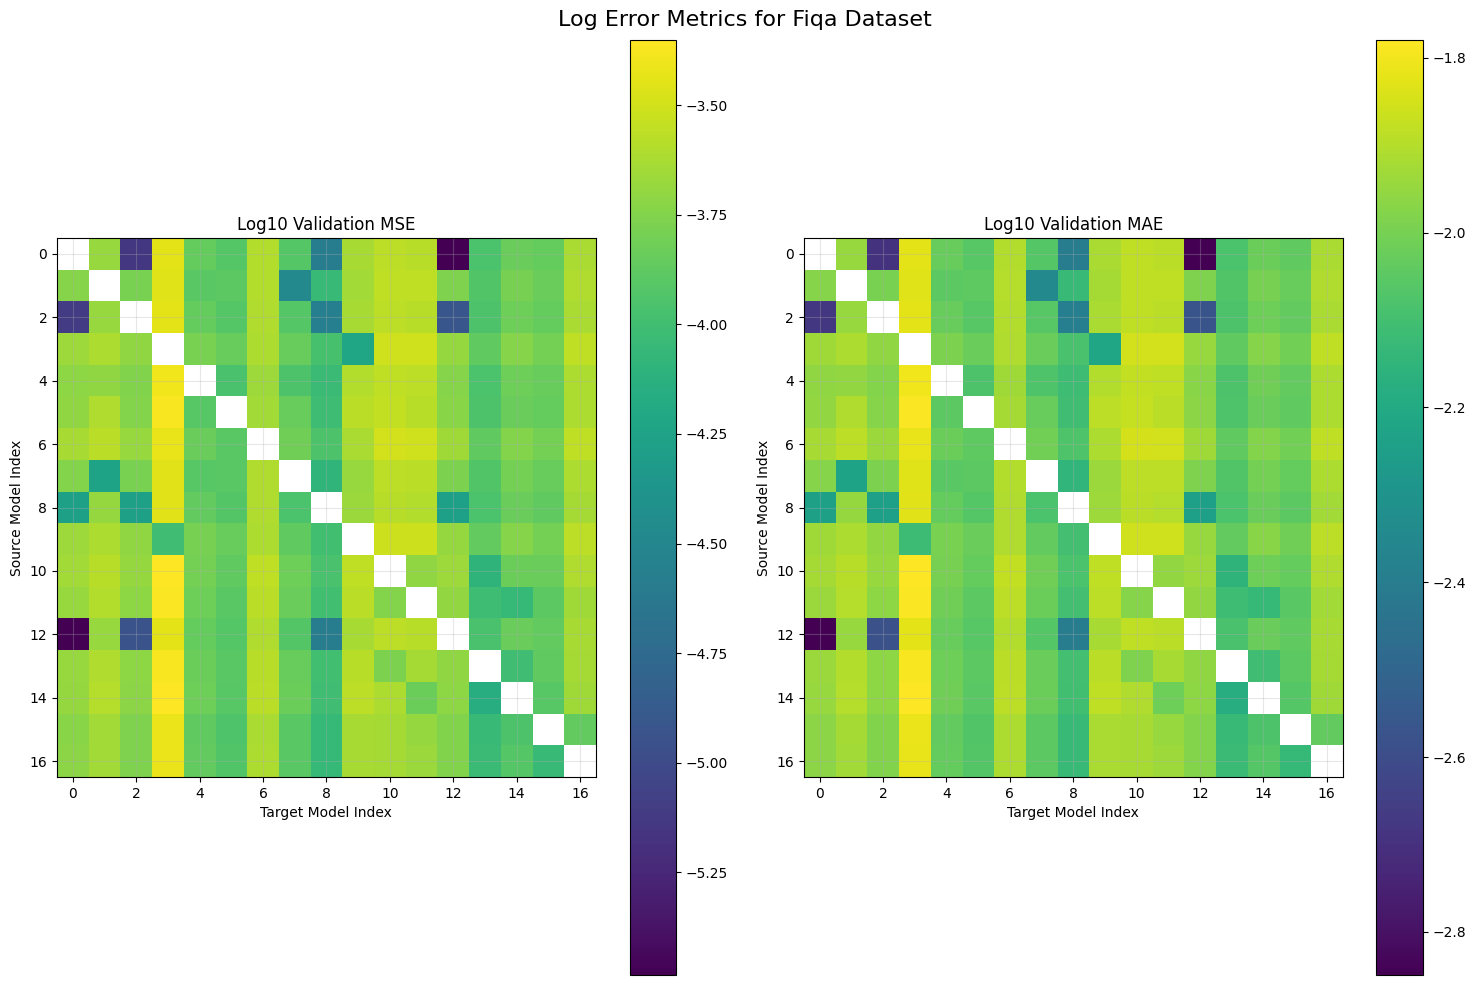

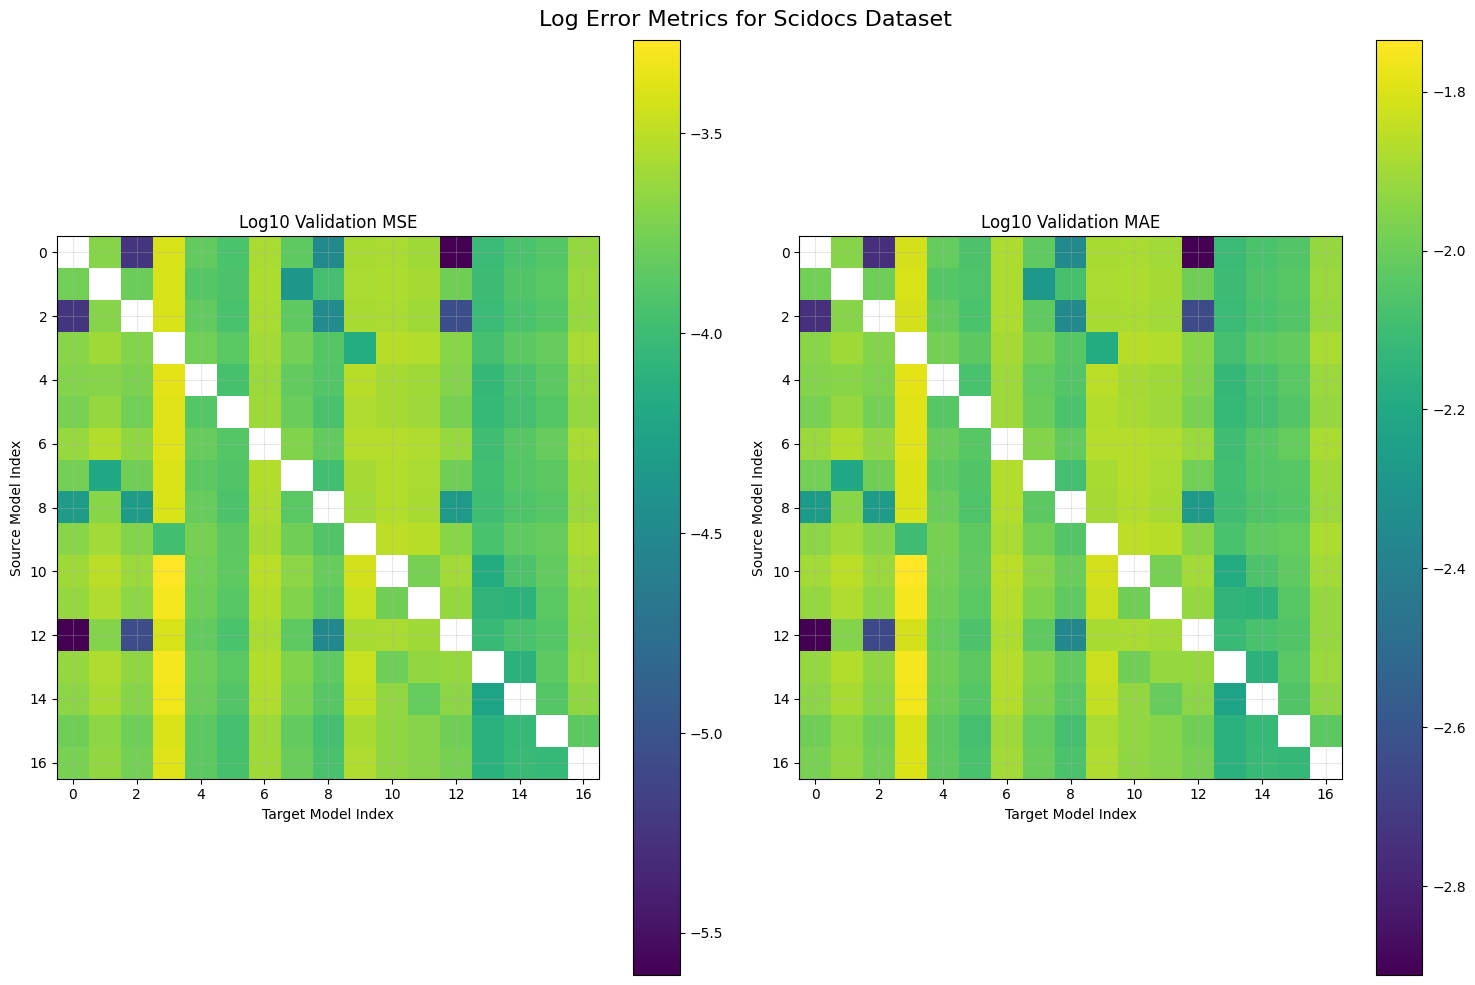

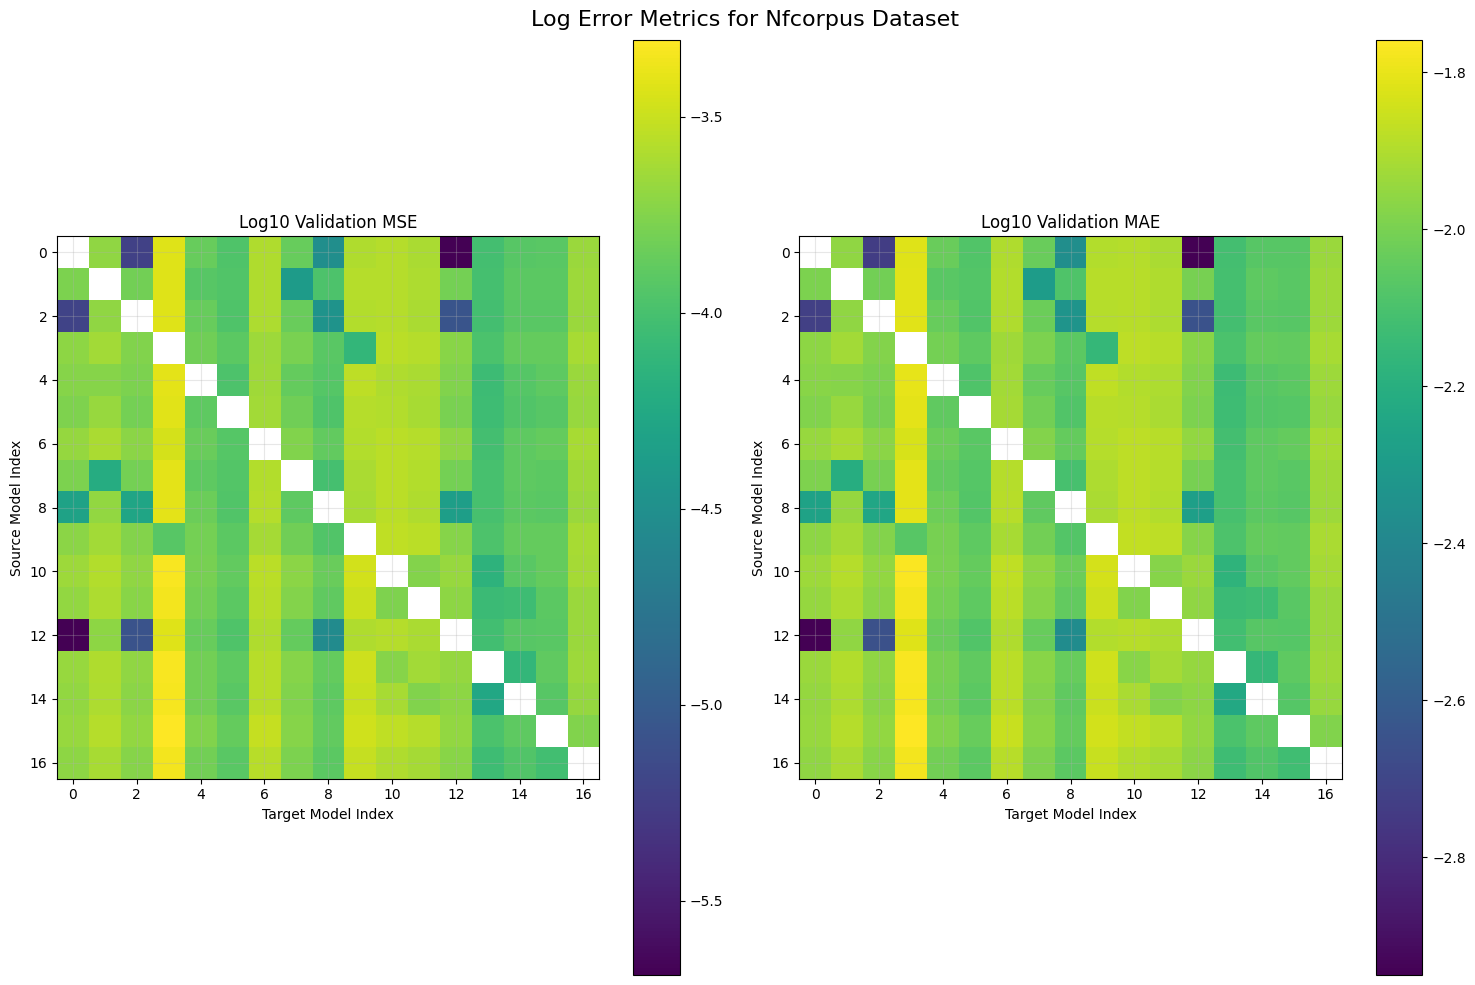

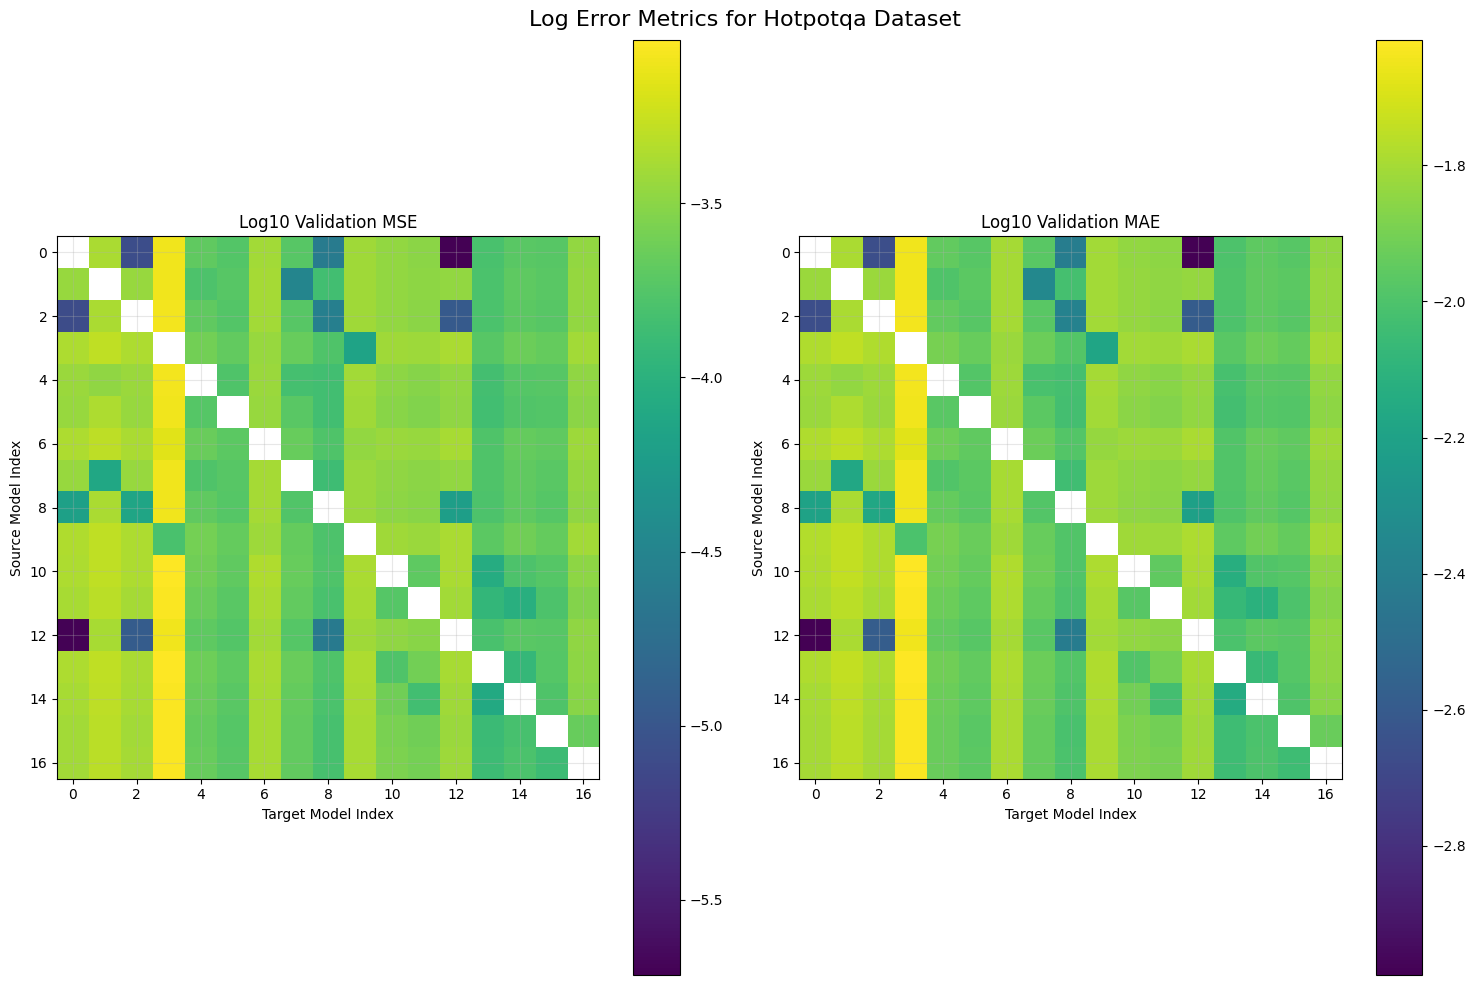

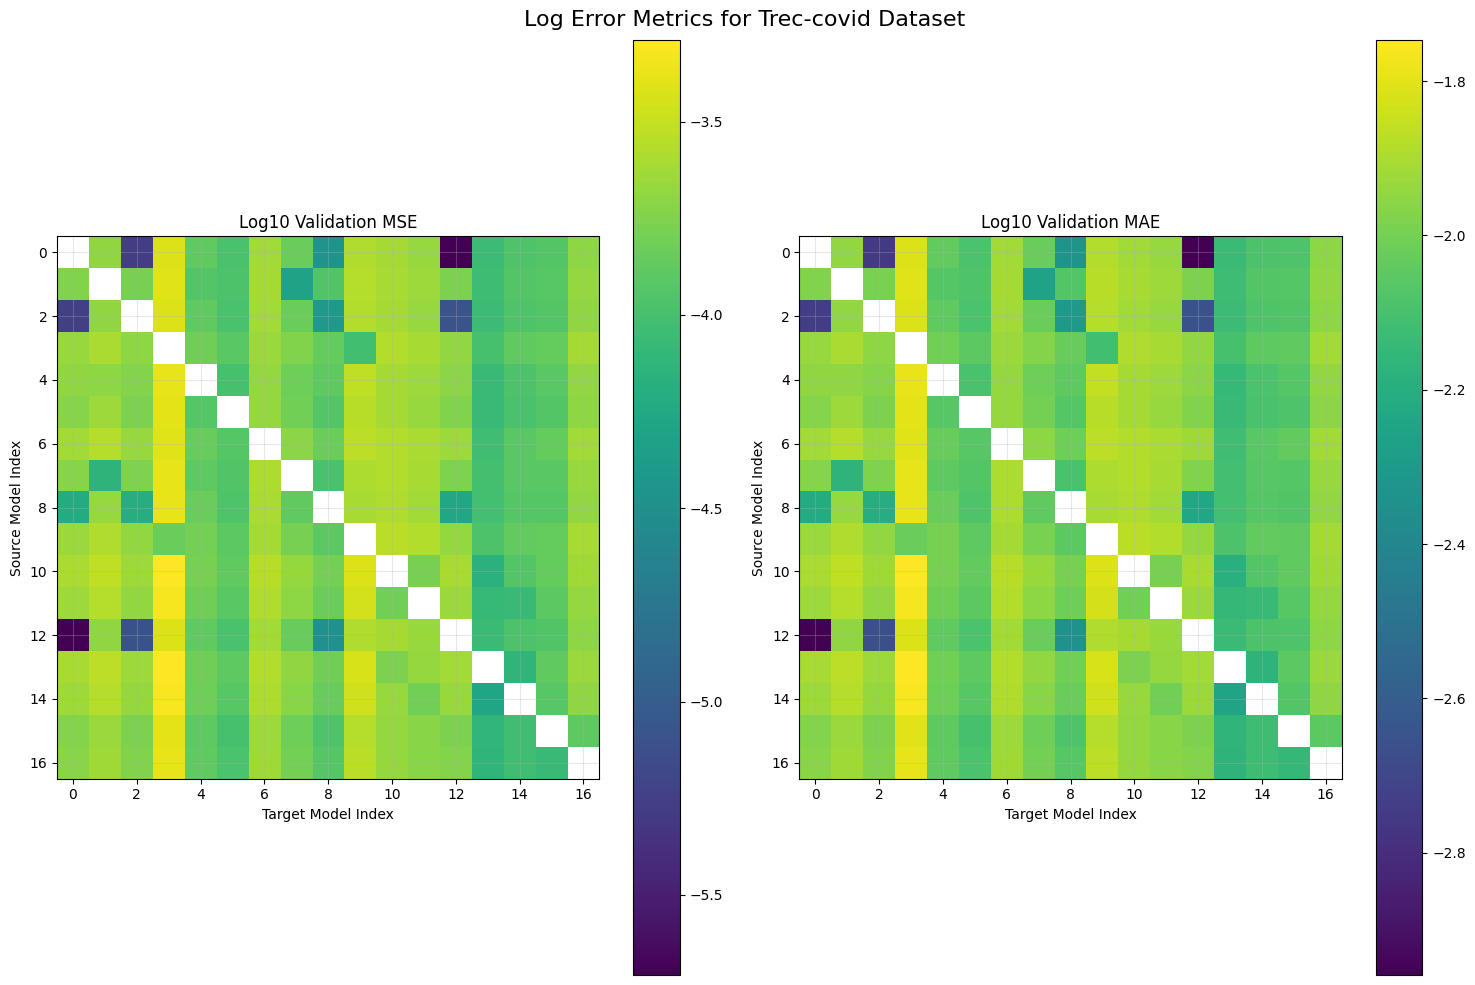

In [40]:
(
    model2idx,
    idx2model,
    dataset2table_train_mse,
    dataset2table_validation_mse,
    dataset2table_train_mae,
    dataset2table_validation_mae
) = creator2.get_all_table_elements()
# plot with log
plot_all_datasets_tables(dataset2table_train_mse, dataset2table_validation_mse, dataset2table_validation_mae, use_log_plot=True)
